# Parametric Pareto Set Learning: Amortizing Multi-Objective Optimization with Parameters

## Introduction

This notebook demonstrates the **PPSL (Parametric Pareto Set Learning)** method for solving Dynamic Multi-Objective Optimization Problems (DMOPs). 

### What are Dynamic Multi-Objective Optimization Problems?

Dynamic Multi-Objective Optimization Problems (DMOPs) are optimization problems where:
- Multiple conflicting objectives need to be optimized simultaneously
- The problem characteristics (objectives, constraints, or Pareto optimal solutions) change over time
- The goal is to track the moving Pareto front as the environment changes

### The PPSL Method

PPSL is a novel approach that leverages deep learning to learn and predict Pareto optimal solutions in dynamic environments. The key components are:

1. **HyperNetwork**: A neural network that generates weights for the Pareto Set Model based on time/environment parameters
2. **Pareto Set Model (PSModel)**: A neural network that maps preference vectors to Pareto optimal solutions
3. **Predictive Parameters**: Time-based parameters that allow the model to adapt to environmental changes

### Key Advantages

- **Continuous Learning**: The model continuously learns the changing Pareto set structure
- **Efficient Adaptation**: Uses hypernetworks to quickly adapt to environmental changes
- **Scalability**: Can handle high-dimensional decision and objective spaces
- **No Population Maintenance**: Unlike evolutionary algorithms, doesn't need to maintain a population over time

## Setup and Installation

First, let's import the necessary libraries and set up the environment.

In [1]:
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

# Import problem and evaluation metrics
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import Hypervolume

# Import our custom modules
from problems.problem import mop_dyn
from trainer import trainer_ppsl_fix_para, generate_ps

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Example: Solving a Dynamic Multi-Objective Problem

Let's demonstrate PPSL on a dynamic test problem. We'll use the DF2 problem, which is a well-known benchmark in the DMOP literature.

In [2]:
# Problem configuration
problem_name = "DF1"  # Dynamic test problem
n_var = 10           # Number of decision variables
tau_t = 10           # Change frequency (generations between environmental changes)
n_t = 10             # Change severity
n_changes = 10       # Number of environmental changes to simulate
pop_size = 200       # Population size for evaluation

# Create the dynamic problem instance
problem = mop_dyn(pname=problem_name, n_dim=n_var, taut=tau_t, nt=n_t)

print(f"Problem: {problem_name.upper()}")
print(f"Decision variables: {n_var}")
print(f"Objectives: {problem.n_obj}")
print(f"Change frequency: every {tau_t} generations")
print(f"Total generations: {n_changes * tau_t}")

Problem: DF1
Decision variables: 10
Objectives: 2
Change frequency: every 10 generations
Total generations: 100


## Training PPSL

Now let's train the PPSL model to track the dynamic Pareto front over time.

In [3]:
# Initialize storage for results
results = {
    'igd': [],
    'hv': [],
    'pareto_fronts': [],
    'true_fronts': [],
    'times': []
}

# Initialize models
hnet, psmodel = None, None
max_n_gen = n_changes * tau_t

print("Starting PPSL training...\n")

# Main training loop
for gen in range(max_n_gen):
    # Create time parameter for current generation
    # We sample 5 preference vectors for each parameter value
    # NOTABLY: we only observe the current genration index with normalization, i.e., gen/max_n_gen
    time_param = torch.ones((int(pop_size / 5), 1)) * (gen / max_n_gen)
    
    # Train the model, we use a two-layer PS model with 256 neurons for the hidden layer
    # The LoRA size is set to 3
    hnet, psmodel = trainer_ppsl_fix_para(
        problem=problem,
        parameters=time_param,
        hnet=hnet,
        psmodel=psmodel,
        hpn_hidden_size=1024,
        psm_hidden_size=512,
        psm_n_layer=2,
        lr_hpn=1e-5,
        lr_base=1e-3,
        loss_type='stch',
        lora_type=True,
        free_rank=3,
        n_sample_pref=5,
        device=device
    )
    
    # Generate Pareto optimal solutions
    # We generate pop_size solutions. More solutions can be obtained in inference time
    pred_ps = generate_ps(
        problem=problem,
        param=torch.tensor([gen / max_n_gen], device=device),
        hypernet=hnet,
        psmodel=psmodel,
        n_samples=500, 
        device=device,
    )
    
    # Evaluate solutions to measure the performance
    pred_front = problem.evaluate(pred_ps).cpu().numpy()
    
    # Calculate metrics at change points
    if (gen + 1) % tau_t == 0:
        true_front = problem._calc_pareto_front(n_pareto_points=pop_size)
        
        # Calculate IGD and HV
        igd = IGD(true_front).do(pred_front)
        hv = Hypervolume(pf=true_front).do(pred_front)
        
        # Store results
        results['igd'].append(igd)
        results['hv'].append(hv)
        results['pareto_fronts'].append(pred_front)
        results['true_fronts'].append(true_front)
        results['times'].append(problem.time)
        
        change_num = (gen + 1) // tau_t
        print(f"Change {change_num}/{n_changes} - Gen {gen+1}: IGD = {igd:.4f}, HV = {hv:.4f}")
    
    # Update problem time
    problem.tic()

print("\nTraining completed!")
print(f"Average IGD: {np.mean(results['igd']):.4e}, STD IGD: {np.std(results['igd']):.4e}")
print(f"Average HV: {np.mean(results['hv']):.4e}, STD HV: {np.std(results['hv']):.4e}")

Starting PPSL training...

Change 1/10 - Gen 10: IGD = 0.0089, HV = 0.4126
Change 2/10 - Gen 20: IGD = 0.0028, HV = 0.3995
Change 3/10 - Gen 30: IGD = 0.0021, HV = 0.3832
Change 4/10 - Gen 40: IGD = 0.0067, HV = 0.3630
Change 5/10 - Gen 50: IGD = 0.0017, HV = 0.3573
Change 6/10 - Gen 60: IGD = 0.0018, HV = 0.3477
Change 7/10 - Gen 70: IGD = 0.0019, HV = 0.3402
Change 8/10 - Gen 80: IGD = 0.0018, HV = 0.3351
Change 9/10 - Gen 90: IGD = 0.0018, HV = 0.3322
Change 10/10 - Gen 100: IGD = 0.0019, HV = 0.3310

Training completed!
Average IGD: 3.1371e-03, STD IGD: 2.4050e-03
Average HV: 3.6017e-01, STD HV: 2.7668e-02


## Visualizing Results

Let's visualize how PPSL tracks the changing Pareto front over time.

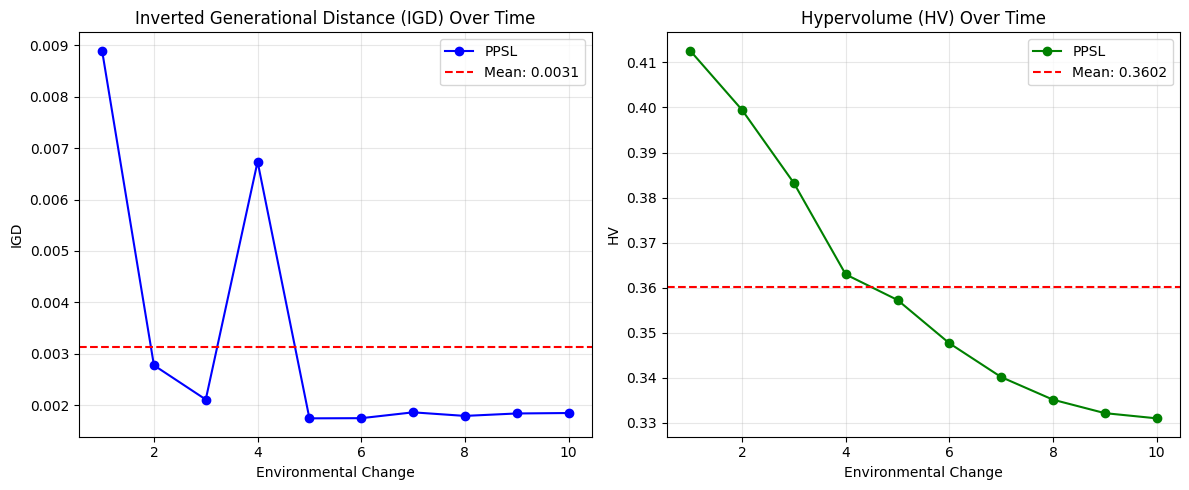

In [4]:
# Plot performance metrics over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# IGD over time
ax1.plot(range(1, len(results['igd'])+1), results['igd'], 'b-o', label='PPSL')
ax1.axhline(y=np.mean(results['igd']), color='r', linestyle='--', label=f"Mean: {np.mean(results['igd']):.4f}")
ax1.set_xlabel('Environmental Change')
ax1.set_ylabel('IGD')
ax1.set_title('Inverted Generational Distance (IGD) Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# HV over time
ax2.plot(range(1, len(results['hv'])+1), results['hv'], 'g-o', label='PPSL')
ax2.axhline(y=np.mean(results['hv']), color='r', linestyle='--', label=f"Mean: {np.mean(results['hv']):.4f}")
ax2.set_xlabel('Environmental Change')
ax2.set_ylabel('HV')
ax2.set_title('Hypervolume (HV) Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

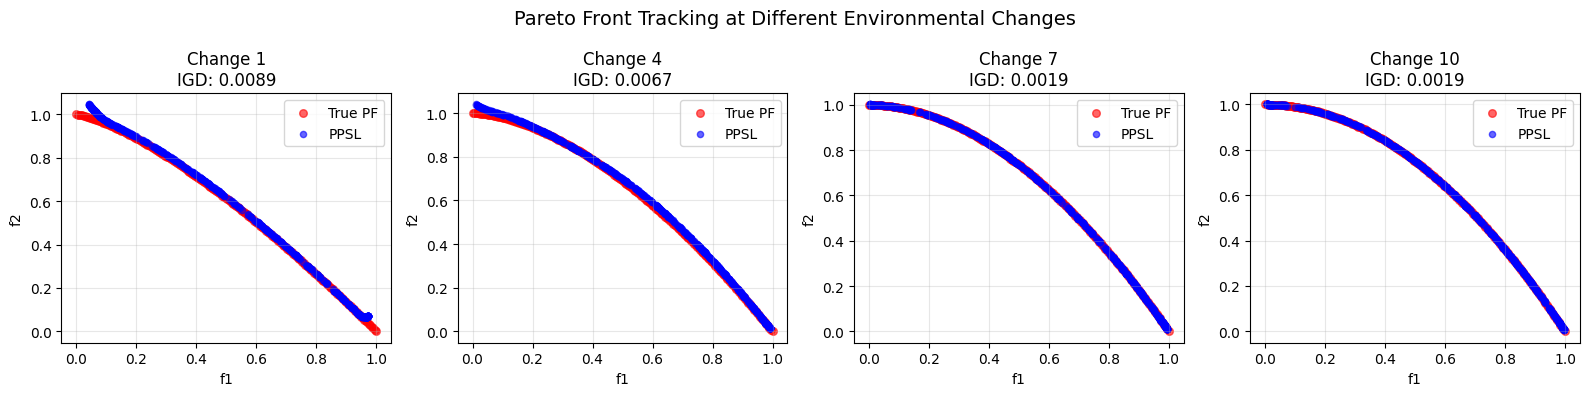

In [5]:
# Visualize Pareto fronts at different time steps
n_plots = min(4, len(results['pareto_fronts']))
indices = np.linspace(0, len(results['pareto_fronts'])-1, n_plots, dtype=int)

fig, axes = plt.subplots(1, n_plots, figsize=(16, 4))
if n_plots == 1:
    axes = [axes]

for i, idx in enumerate(indices):
    ax = axes[i]
    
    # Plot true Pareto front
    true_front = results['true_fronts'][idx]
    ax.scatter(true_front[:, 0], true_front[:, 1], c='red', alpha=0.6, s=30, label='True PF')
    
    # Plot predicted Pareto front
    pred_front = results['pareto_fronts'][idx]
    ax.scatter(pred_front[:, 0], pred_front[:, 1], c='blue', alpha=0.6, s=20, label='PPSL')
    
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    ax.set_title(f'Change {idx+1}\nIGD: {results["igd"][idx]:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Pareto Front Tracking at Different Environmental Changes', fontsize=14)
plt.tight_layout()
plt.show()

## Understanding PPSL Components

Let's examine the key components of PPSL in more detail.

In [6]:
# Examine model architectures
print("PPSL Architecture Summary:")
print("=" * 50)
print(f"\n1. HyperNetwork:")
print(f"   - Input: Time parameter (1D)")
print(f"   - Hidden size: 1024")
print(f"   - Output: Weights for PSModel")
print(f"   - Uses LoRA adaptation with rank {3}")

print(f"\n2. Pareto Set Model (PSModel):")
print(f"   - Input: Preference vector ({problem.n_obj}D)")
print(f"   - Hidden size: 512")
print(f"   - Layers: 2")
print(f"   - Output: Decision variables ({n_var}D)")

print(f"\n3. Training Strategy:")
print(f"   - Loss type: Stochastic Chebyshev (stch)")
print(f"   - Learning rate (HyperNet): 1e-5")
print(f"   - Learning rate (PSModel): 1e-3")
print(f"   - Samples per preference: 5")

PPSL Architecture Summary:

1. HyperNetwork:
   - Input: Time parameter (1D)
   - Hidden size: 1024
   - Output: Weights for PSModel
   - Uses LoRA adaptation with rank 3

2. Pareto Set Model (PSModel):
   - Input: Preference vector (2D)
   - Hidden size: 512
   - Layers: 2
   - Output: Decision variables (10D)

3. Training Strategy:
   - Loss type: Stochastic Chebyshev (stch)
   - Learning rate (HyperNet): 1e-5
   - Learning rate (PSModel): 1e-3
   - Samples per preference: 5


## Interactive Demo: Generate Solutions at Any Time

One key advantage of PPSL is that once trained, it can generate Pareto optimal solutions for any time point, even between the discrete time steps used during training.

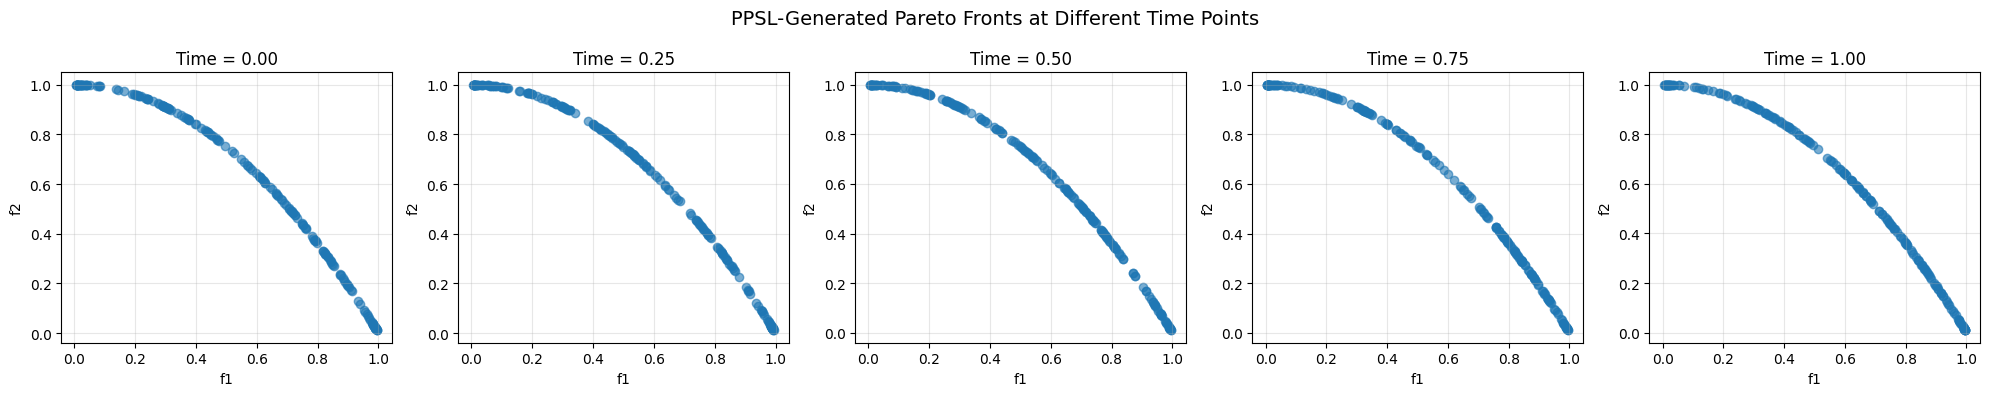

In [7]:
def generate_solutions_at_time(time_ratio, n_samples=100):
    """
    Generate Pareto optimal solutions at a specific time point.
    
    Args:
        time_ratio: Time parameter between 0 and 1 (0 = start, 1 = end)
        n_samples: Number of solutions to generate
    """
    # Generate solutions
    solutions = generate_ps(
        problem=problem,
        param=torch.tensor([time_ratio], device=device),
        hypernet=hnet,
        psmodel=psmodel,
        n_samples=n_samples,
        device=device,
    )
    
    # Evaluate objectives
    objectives = problem.evaluate(solutions).cpu().numpy()
    
    return solutions.cpu().numpy(), objectives

# Example: Generate solutions at different time points
time_points = [0.0, 0.25, 0.5, 0.75, 1.0]
fig, axes = plt.subplots(1, len(time_points), figsize=(20, 4))

for i, t in enumerate(time_points):
    _, objectives = generate_solutions_at_time(t, n_samples=200)
    
    axes[i].scatter(objectives[:, 0], objectives[:, 1], alpha=0.6)
    axes[i].set_xlabel('f1')
    axes[i].set_ylabel('f2')
    axes[i].set_title(f'Time = {t:.2f}')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('PPSL-Generated Pareto Fronts at Different Time Points', fontsize=14)
plt.tight_layout()
plt.show()

## Comparison with Traditional Methods

PPSL offers several advantages over traditional dynamic multi-objective evolutionary algorithms:

1. **Continuous Adaptation**: While evolutionary algorithms typically restart or use special diversity mechanisms when the environment changes, PPSL continuously learns the underlying mapping from time to Pareto sets.

2. **Interpolation Capability**: PPSL can generate solutions for any time point, not just the discrete generations used during training.

3. **Efficient Computation**: Once trained, generating new solutions is just a forward pass through the neural networks, which is much faster than running evolutionary operators.

4. **Memory of Past Solutions**: The neural networks implicitly remember the structure of past Pareto sets, potentially allowing better prediction of future changes.

## Conclusion

This notebook demonstrated the PPSL method for dynamic multi-objective optimization. Key takeaways:

- PPSL uses neural networks to learn the mapping from time parameters and preferences to Pareto optimal solutions
- The method can efficiently track changing Pareto fronts in dynamic environments
- Once trained, PPSL can generate solutions at any time point through simple forward passes

### Further Reading

For more details about the method and its theoretical foundations, please refer to our paper:

*[]*

### Contact

For questions or suggestions, please contact: *[]*